In [112]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.stats import norm
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from numpy.random import normal

from astropy.table import Table
from lifelines import KaplanMeierFitter
import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm

In [2]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [142]:
def gaussian_pdf(x,params):
    mean,sig = params
    return(1/(np.sqrt(2*np.pi)*sig)*np.exp(-((x-mean)**2/(2*sig**2))))

In [149]:
def log_normal(x,mean,sig,theta):
    y = np.exp(-(np.log((x-theta)/mean))**2/(2*sig**2)) / ( (x-theta) * sig*np.sqrt(2*np.pi))
    return(y)

In [118]:
def straight_line(x,params):
    m,c = params
    y = m*x + c
    return(y)

In [61]:
def gurkan_fit(L150,a,b):
    # L150 = L250**1.15*10**(-5.05)
    L250 = (L150 / 10**(b))**(1/a)
    return(L250)

In [62]:
def gurkan_calc_l250(l150):
    a_err = normal(1.15,0.03,len(l150))
    b_err = normal(-5.05,0.65,len(l150))
    l250 = gurkan_fit(l150,a_err,b_err)
    return(l250)

In [82]:
def gurkan_calc_l250_agn(l150):
    a_err = normal(1.65,0.03,len(l150))
    b_err = normal(-3.05,0.65,len(l150))
    l250 = gurkan_fit(l150,a_err,b_err)
    return(l250)

In [3]:
def agn_luminosity_function(L):
    #returns N for the luminsity function from Heckman and Best 2014 page 615
    A = 10**(-5.33)
    P0 = 10**24.95
    alpha = 0.42
    beta = 1.66
    
    N = A/((L/P0)**alpha + (L/P0)**beta)
    return(N)

In [4]:
def sf_luminosity_function(L):
    #returns the luminosity function from Mauch and Sadler 2007
    C = 10**(-2.83)
    P0 = 10**(21.18)
    sig = 0.6
    alpha = 1.02
    
    N = C*(L/P0)**(1-alpha) * np.exp(-0.5*((np.log10(1+L/P0)/sig)**2))
    return(N)

In [5]:
def mcmc_sample_from_pdf(func,N,xmin,xmax,ymin,ymax):
    x = []
    for n in range(N):
        x.append(random.random())
    x = np.array(x)
    x = x+xmin + (x*(xmax-xmin))

    y = []
    for n in range(N):
        y.append(random.random())
    y = np.array(y)
    y = y+ymin + (y*(ymax-ymin))
    
    test = func(10**x)
    mask = y<np.log10(test)
    
    return(x[mask])

In [6]:
def get_fir_lum(L,q,sig):
    #given the radio luminosity of a source (in W) it will return a FIR luminosity based on a FIRC 
    #from a given q value and scatter sig
    noise = np.random.normal(0,sig,len(L))
    q = q + noise
    fir = q + np.log10(L) + np.log10(3.75E12)
    return(fir)

In [30]:
def calc_Q(l_fir,l_rad):
    Q = np.log10(l_fir) - np.log10(l_rad)
    return(Q)

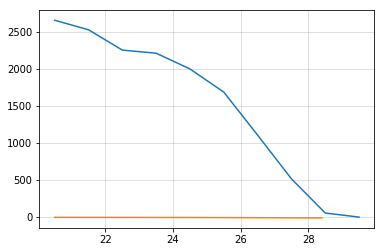

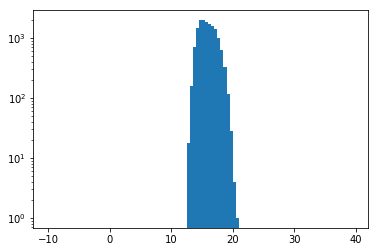

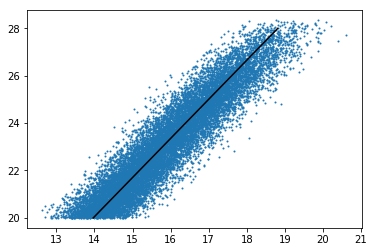

In [83]:
agn_lum = 10**mcmc_sample_from_pdf(agn_luminosity_function,30000,20,30,np.log10(agn_luminosity_function(1E20)),np.log10(agn_luminosity_function(1E29)))

bins = np.arange(20,30.1,1)
x = get_center(bins)
y,_ = np.histogram(np.log10(agn_lum),bins=bins)
plt.plot(x,y)

x = np.arange(20.5,28.5,0.1)
y = agn_luminosity_function(10**x)
plt.plot(x,np.log10(y))
plt.grid(alpha=0.5)
plt.show()

agn_lum_fir = gurkan_calc_l250_agn(agn_lum)
y = np.log10(agn_lum_fir) #- np.log10(3E26)
bins=np.arange(-10,40,0.5)
plt.hist(y,bins=bins,log=True)
plt.show()

plt.scatter(np.log10(agn_lum_fir),np.log10(agn_lum),s=1)
x = np.arange(20,28,0.01)
#to estimate an agn FIRC relation i increases the normalistaion by 2 and increased the scatter by 0.5
y = gurkan_fit(10**x,1.65,-3.05)
plt.plot(np.log10(y),x,c='black')
#Q = calc_Q(sf_lum_fir,sf_lum)
#plt.hist(Q,bins=np.arange(-20,20,0.1),log=True)
plt.show()

In [60]:
gurkan_calc_l250([1E23])

array([4.15787135e+15])

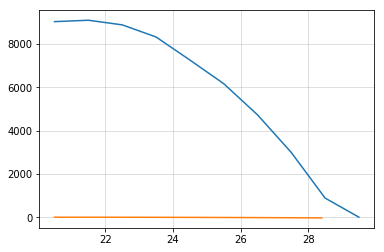

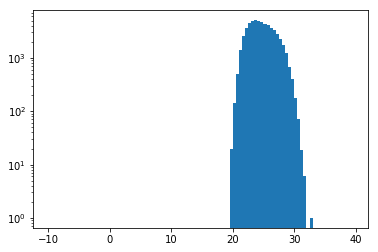

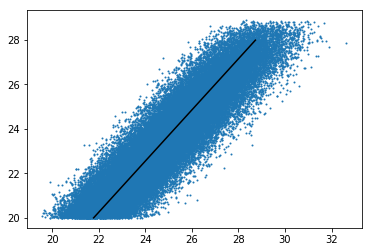

In [70]:
sf_lum = 10**mcmc_sample_from_pdf(sf_luminosity_function,100000,20,30,np.log10(sf_luminosity_function(1E20)),np.log10(sf_luminosity_function(1E29)))

bins = np.arange(20,30.1,1)
x = get_center(bins)
y,_ = np.histogram(np.log10(sf_lum),bins=bins)
plt.plot(x,y)

x = np.arange(20.5,28.5,0.1)
y = sf_luminosity_function(10**x)
plt.plot(x,np.log10(y))
plt.grid(alpha=0.5)
plt.show()

sf_lum_fir = gurkan_calc_l250(sf_lum)
y = np.log10(sf_lum_fir) #- np.log10(3E26)
bins=np.arange(-10,40,0.5)
plt.hist(y,bins=bins,log=True)
plt.show()

plt.scatter(np.log10(sf_lum_fir),np.log10(sf_lum),s=1)
x = np.arange(20,28,0.01)
y = gurkan_fit(10**x,1.15,-5.05)
plt.plot(np.log10(y),x,c='black')
#Q = calc_Q(sf_lum_fir,sf_lum)
#plt.hist(Q,bins=np.arange(-20,20,0.1),log=True)
plt.show()

In [105]:
rad_lum = np.log10(np.concatenate([agn_lum,sf_lum]))
fir_lum = np.log10(np.concatenate([agn_lum_fir,sf_lum_fir]))

zmin = 0.8
zmax = 1.0
z = []
for n in range(len(fir_lum)):
    z.append(random.random())
z = np.array(z)
z = zmin + (z*(zmax-zmin))
dist = cosmo.luminosity_distance(z).to(u.m).value
fir_flux = 10**fir_lum/(4*np.pi*dist**2)*1E29

detection = fir_flux>5
fir_lum[~detection] = np.log10(5*1E-29 * 4*np.pi*dist[~detection]**2)

In [107]:
np.max(fir_lum)

32.64208262274264

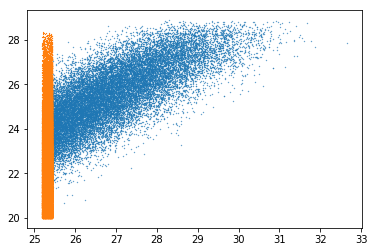

In [110]:
x = fir_lum[detection]
y = rad_lum[detection]
plt.scatter(x,y,s=0.1)

x = fir_lum[~detection]
y = rad_lum[~detection]
plt.scatter(x,y,s=0.1,marker='<')

measured median using survival analysis is: 2.1322884669109605


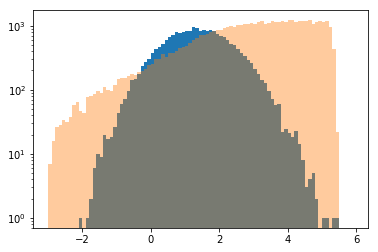

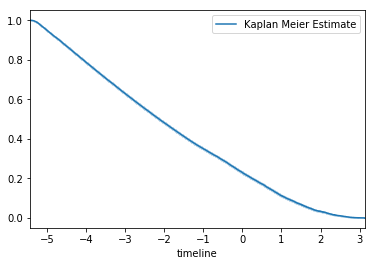

In [136]:
q =fir_lum - rad_lum
const = 0
data=const - q
det = ~detection
kmf = KaplanMeierFitter() 

bins=np.arange(-3,6,0.1)
plt.hist(q[detection],bins=bins,log=True)
plt.hist(q[~detection],bins=bins,log=True,alpha=0.4)
## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')

## Create an estimate
print('measured median using survival analysis is: {}'.format(const - kmf.median_))
kmf.plot()
plt.show()

In [137]:
kmf.median_

-2.1322884669109605

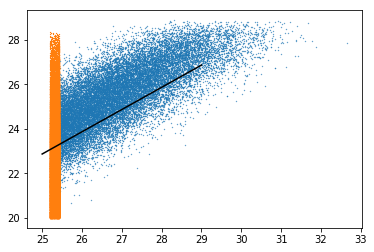

In [139]:
x = fir_lum[detection]
y = rad_lum[detection]
plt.scatter(x,y,s=0.1)

x = fir_lum[~detection]
y = rad_lum[~detection]
plt.scatter(x,y,s=0.1,marker='<')

x = np.arange(25,30,1)
y = straight_line(x,[1,kmf.median_])
plt.plot(x,y,c='black')
plt.show()

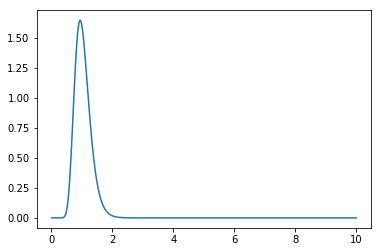

In [152]:
x = np.arange(-10,10,0.01)
y = log_normal(x,1,0.25,0)

plt.plot(x,y)